<h1 style="text-align: center;"> Training from Scratch </h1>

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
 
import deeplabv3p

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

2.1.0


### Dummy Data Generation

In [2]:
def gen_circle_and_label(s, noise_strength=0.05):
    """
    Generate a noisy image of size s with a circle and its
    corresponding labelled image.
    """
    s_mean = (s[0]+s[1])/2

    min_radius = s_mean//4
    max_radius = s_mean//2
    radius = random.randint(min_radius, max_radius)

    x0 = random.randint(0,s[0]-1)
    y0 = random.randint(0,s[1]-1)

    x, y = np.mgrid[0:s[0],0:s[1]]
    label = ((x-x0)**2 + (y-y0)**2 < radius**2).astype(int)

    color_background = random.random()
    color_circle = random.random()

    circle = label * color_circle + (1-label) * color_background
    circle += noise_strength * 2*(np.random.rand(s[0],s[1])-0.5)
    circle *= 255
    circle = circle.astype(np.uint8)
    
    return circle, label

In [6]:
# Create circle images test data
images = []
labels = []
size = (50,50)
n = 25000
for i in range(n):
    circle, label = gen_circle_and_label(size)
    images.append(circle)
    labels.append(label)

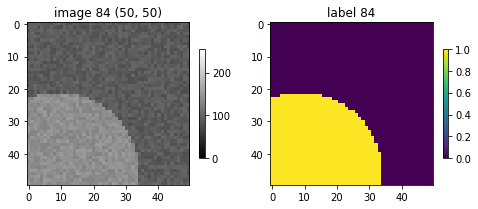

In [7]:
# Plot a random sample

i = random.randint(0,len(images)) 
    
fig, axs = plt.subplots(1,2, figsize=(8,4))

im = axs[0].imshow(images[i], cmap='gray', vmin=0, vmax=255)
axs[0].set_title(f'image {i} {images[i].shape}')
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(labels[i], vmin=0)
axs[1].set_title(f'label {i}')
plt.colorbar(im, ax=axs[1], shrink=0.5)

plt.show()

### Neural Network

In [6]:
n_classes = 2
model = deeplabv3p.DeepLabV3p(weights=None, input_shape=(50,50,1), classes=n_classes, backbone='mobilenetv2')

In [7]:
loss = deeplabv3p.create_sparse_categorical_crossentropy()

metrics = [
    deeplabv3p.create_pixel_accuracy(n_classes),
    deeplabv3p.create_pixel_accuracy_ignoring_void(n_classes)
]

optimizer = Adam()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

X = np.expand_dims(np.array(images), axis=-1)
Y = np.expand_dims(np.array(labels), axis=-1).reshape(len(labels),-1,1)

### Training and Saving

In [ ]:
h = model.fit(x=X, y=Y, batch_size=16, epochs=5, validation_split=0.1)

In [ ]:
model.save('models/model.h5')
model.save('models/model_without_optimizer.h5', include_optimizer=False)
del model

### Loading and Inference

In [10]:
n_classes = 2
custom_objects = {
    'relu': tf.keras.activations.relu,
    'resize_bilinear': tf.image.resize,
    'pixel_accuracy': deeplabv3p.create_pixel_accuracy(n_classes),
    'pixel_accuracy_ignoring_void': deeplabv3p.create_pixel_accuracy_ignoring_void(n_classes)
}
model = tf.keras.models.load_model('models/model.h5', custom_objects=custom_objects)

In [11]:
# model = tf.keras.models.load_model('models/model_without_optimizer.h5')

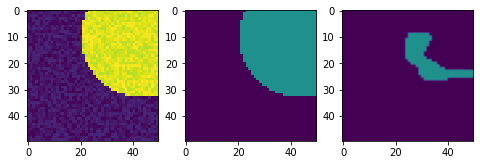

In [23]:
# generate data
size = (50,50)
circle, label = gen_circle_and_label(size)

# preprocessing, prediction, post processing
x = circle[np.newaxis,..., np.newaxis]
y_pred = model.predict(x)
y_pred = np.argmax(y_pred, axis=-1).reshape(-1,size[0],size[1])[0]

# plot
fig, axs = plt.subplots(1,3, figsize=(8,4))
axs[0].imshow(circle, interpolation='None')
axs[1].imshow(label, interpolation='None', vmin=0, vmax=2)
axs[2].imshow(y_pred, vmin=0, vmax=2)
plt.show()